In [ ]:
#ディリクレ過程を使ったクラスタリングの基本プログラム
#2021年1月23日からリアルデータに拡張して作成

In [224]:
from __future__ import print_function
import argparse
import torch
from torch.utils import data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

%matplotlib inline
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np


from sklearn.manifold import TSNE
from random import random
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans

import math

import os
from PIL import Image
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable


import glob
import torchvision.transforms as transforms
import torchvision
from sklearn.model_selection import train_test_split
import pickle
import copy

In [225]:
X_p_l10 = np.load('../../MNIST/VAE/clustering-during-VAE/gmm-resnet-results/data/mus_g_N10000_L10_ep150_bs50_res101.npy')
ts_p_l10 = np.load('../../MNIST/VAE/clustering-during-VAE/gmm-resnet-results/data/ts_g_N10000_L10_ep150_bs50_res101.npy')
initial_data_dim = X_p_l10.shape[1]


#X_p_l10 = np.load('../../MNIST/VAE/clustering-during-VAE/gmm-resnet-results/data/mus_g_N10000_L10_ep150_bs50_beta192.0_res101.npy')
#ts_p_l10 = np.load('../../MNIST/VAE/clustering-during-VAE/gmm-resnet-results/data/ts_g_N10000_L10_ep150_bs50_beta192.0_res101.npy')
#initial_data_dim = X_p_l10.shape[1]


real_cluster_number = 10
N_data_one_cluster =100

In [226]:
#X_p_l5 = np.load('../../MNIST/VAE/clustering-during-VAE/gmm-resnet-results/data/mus_g_N10000_L5_ep150_bs50_res101.npy')
#ts_p_l5 = np.load('../../MNIST/VAE/clustering-during-VAE/gmm-resnet-results/data/ts_g_N10000_ep150_bs50_res101.npy')
#initial_data_dim = X_p_l10.shape[1]
N_sample = 1000
X_2d_p_data = X_p_l10.squeeze()[0:N_sample]
ts_p_data = ts_p_l10[0:N_sample]

In [227]:
X_2d_p_data.shape,ts_p_data.shape


((1000, 10), (1000,))

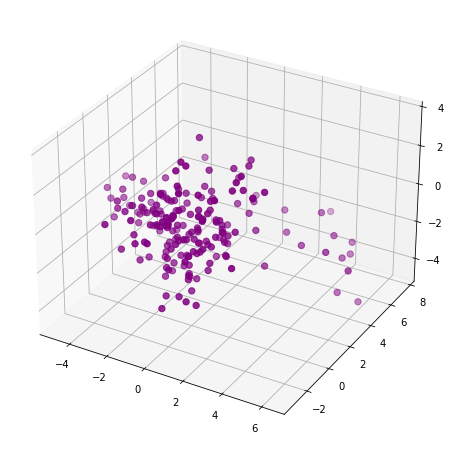

In [228]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_2d_p_data[:200,0], X_2d_p_data[:200,1], X_2d_p_data[:200,2], s = 40, c = "purple")
plt.show()

In [229]:
def log_P_func(l_f,latent_data_f,pick_up_number_f,dirichlet_alpha_f,pre_nu_f,pre_beta_f,pre_mu_0_f,S_0_inv_f):

    cluster_data = latent_data_f[l_f]
    cluster_center = cluster_data.mean(axis=0)
    n_prime = len(l_f)
    mu_c = (n_prime*cluster_center+pre_beta_f*pre_mu_0_f)/(n_prime+pre_beta_f)
#    mu_c = n_prime*cluster_center
#    mu_c +=pre_beta_f*pre_mu_0_f
#    mu_c/=(n_prime+pre_beta_f)

    S_q_inv = S_0_inv_f + n_prime*np.cov(cluster_data,rowvar=0,bias=1) + n_prime*pre_beta_f*np.outer(cluster_center-pre_mu_0_f,cluster_center-pre_mu_0_f)/(n_prime + pre_beta_f)
    S_r_inv = S_q_inv + (n_prime + pre_beta_f)*np.outer(latent_data_f[pick_up_number_f]-mu_c,latent_data_f[pick_up_number_f]-mu_c)/(n_prime + pre_beta_f+1)
    data_dim = latent_data_f[pick_up_number_f].shape[0]
    n_total = latent_data_f.shape[0]
#    print("n_prime={}".format(n_prime))
#    print("cluster_center={}".format(cluster_center))
#    print("mu_c={}".format(mu_c))
#    print("S_q_inv={}".format(S_q_inv))
#    print("S_r_inv={}".format(S_r_inv))
#    print("data_dim={}".format(data_dim))
#    print("n_total={}".format(n_total))

#    return S_r_inv,S_q_inv
#    return np.log(n_prime/(n_total-1+dirichlet_alpha_f))+0.5*data_dim*np.log((n_prime+pre_beta_f)/(n_prime+pre_beta_f+1)/math.pi) - 0.5*(pre_nu_f + n_prime +1)*np.log(S_r_inv)+0.5*(pre_nu_f + n_prime)*np.log(S_q_inv)+math.lgamma(0.5*(pre_nu_f+n_prime+1))-math.lgamma(0.5*(pre_nu_f+n_prime+1-data_dim))
    return np.log(n_prime/(n_total-1+dirichlet_alpha_f))+0.5*data_dim*np.log((n_prime+pre_beta_f)/(n_prime+pre_beta_f+1)/math.pi) - 0.5*(pre_nu_f + n_prime +1)*np.log(np.linalg.det(S_r_inv))+0.5*(pre_nu_f + n_prime)*np.log(np.linalg.det(S_q_inv))+math.lgamma(0.5*(pre_nu_f+n_prime+1))-math.lgamma(0.5*(pre_nu_f+n_prime+1-data_dim))


def log_P_new_func(latent_data_f,pick_up_number_f,dirichlet_alpha_f,pre_nu_f,pre_beta_f,pre_mu_0_f,S_0_inv_f):

    picked_data = latent_data_f[pick_up_number_f]
    S_b_inv = S_0_inv_f + pre_beta_f*np.outer(picked_data-pre_mu_0_f,picked_data-pre_mu_0_f)/(pre_beta_f+1)
    data_dim = picked_data.shape[0]
    n_total = latent_data_f.shape[0]

#    print("S_0_inv={}".format(S_0_inv_f))
#    print("S_b_inv={}".format(S_b_inv))
#    print("data_dim={}".format(data_dim))
#    print("n_total={}".format(n_total))

    return np.log(dirichlet_alpha_f/(n_total-1+dirichlet_alpha_f))+0.5*data_dim*np.log(pre_beta_f/(pre_beta_f+1)/math.pi) - 0.5*(pre_nu_f + 1)*np.log(np.linalg.det(S_b_inv))+0.5*pre_nu_f*np.log(np.linalg.det(S_0_inv_f))+math.lgamma(0.5*(pre_nu_f+1))-math.lgamma(0.5*(pre_nu_f+1-data_dim))
#    return np.log(dirichlet_alpha_f/(n_total-1+dirichlet_alpha_f))+0.5*data_dim*np.log(pre_beta_f/(pre_beta_f+1)/math.pi) - 0.5*(pre_nu_f + 1)*np.log(S_b_inv)+0.5*pre_nu_f*np.log(S_0_inv_f)+math.lgamma(0.5*(pre_nu_f+1))-math.lgamma(0.5*(pre_nu_f+1-data_dim))

In [230]:
def sum_del_log_gamma(nu,n,dim):
    x=0
    for i in range(dim):
       x+= math.lgamma(0.5*(nu+n-i))-math.lgamma(0.5*(nu-i))
    return x

def log_P_total(list_list,latent_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv):

    cluster_number = len(list_list)
    data_dim = latent_data[0].shape[0]
    n_total = latent_data.shape[0]

    log_P = cluster_number*np.log(dirichlet_alpha)-math.lgamma(dirichlet_alpha+n_total)+ math.lgamma(dirichlet_alpha)
    for l in list_list:
        number_in_cluster = len(l)
        data_l = latent_data[l]
        data_l_av = data_l.mean(axis=0)
        S_q_inv = S_0_inv + number_in_cluster*np.cov(data_l,rowvar=0,bias=1)+ number_in_cluster*pre_beta*np.outer(data_l_av-pre_mu_0,data_l_av-pre_mu_0)/(number_in_cluster+pre_beta)
#        log_P += math.lgamma(number_in_cluster) -0.5*(pre_nu+number_in_cluster)*np.log(S_q_inv) +0.5*pre_nu*np.log(S_0_inv)+sum_del_log_gamma(pre_nu,number_in_cluster,data_dim)+0.5*data_dim*(np.log(pre_beta/(number_in_cluster+pre_beta))-number_in_cluster*np.log(math.pi))
        log_P += math.lgamma(number_in_cluster) -0.5*(pre_nu+number_in_cluster)*np.log(np.linalg.det(S_q_inv)) +0.5*pre_nu*np.log(np.linalg.det(S_0_inv))+sum_del_log_gamma(pre_nu,number_in_cluster,data_dim)+0.5*data_dim*(np.log(pre_beta/(number_in_cluster+pre_beta))-number_in_cluster*np.log(math.pi))

    return log_P

In [231]:
def softmax(a):
    # 一番大きい値を取得
    c = np.max(a)
    # 各要素から一番大きな値を引く（オーバーフロー対策）
    exp_a = np.exp(a - c)
    sum_exp_a = np.sum(exp_a)
    # 要素の値/全体の要素の合計
    y = exp_a / sum_exp_a
    return y

In [232]:
def cluster_prob(list_list,latent_data,pick_up_number,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv):

    for l in list_list:
        if pick_up_number in l:
            current_place = list_list.index(l)
            list_list[current_place].remove(pick_up_number)

    for x in list_list:
        if x == []:
#            disappearing_index = list_list.index(x)
            list_list.remove(x)

    log_P = np.empty(len(list_list)+1)
    for i, l in enumerate(list_list):
        log_P[i] = log_P_func(l,latent_data,pick_up_number,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)

    log_P[len(list_list)] = log_P_new_func(latent_data,pick_up_number,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)

    return softmax(log_P)

In [233]:
def show_mean_cov(X_data,list_list):

    N_cluster = len(list_list)
    for i in range(N_cluster):
        X_0 = X_data[list_list[i]]
        print("--cluster{}--".format(i))
        print("N_member_{}={}".format(i,len(list_list[i])))
        print("Mean_{}={}".format(i,X_0.mean(axis=0)))
        print("Cov_{}=\n{}\n".format(i,np.cov(X_0,rowvar=0,bias=1)))


In [234]:
cm = plt.cm.get_cmap('tab20')
def drawpoints_with_centers(mus_numpy,ts_numpy,list_list):
    for p,l in zip(mus_numpy,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color=cm.colors[l])

    N_cluster = len(list_list)
    X_mean = np.empty([N_cluster,2])
    for i in range(N_cluster):
        X_mean[i] = mus_numpy[list_list[i]].mean(axis=0)
    for p in X_mean:
        plt.scatter(p[0],p[1],facecolors='none',edgecolors='red',s=200)
    for i, p in enumerate(X_mean):
        plt.scatter(p[0],p[1],marker="${}$".format(i),color='black',s=50)
    plt.show()

In [235]:
cm = plt.cm.get_cmap('tab20')
def drawpoints_3d(mus_numpy,ts_numpy):
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection='3d')
#    for i in range(len(list_list)):
#        ax.scatter(mus_numpy[list_list[i],0], mus_numpy[list_list[i],1], mus_numpy[list_list[i],2], s = 40, color=cm.colors[i])
    for p,l in zip(mus_numpy,ts_numpy):
        ax.scatter(p[0],p[1],marker="${}$".format(l),color=cm.colors[l])

    plt.show()

In [236]:
def clustering_index(list_list):

    total_N =0
    for l in list_list:
        total_N += len(l)

    ts = np.empty(total_N)
    for i, l in enumerate(list_list):
        ts[l] = i

    return ts.astype(int)

In [237]:
def one_epoch(list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv):
    for pick_up_index in range(X_data.shape[0]):
        probability = cluster_prob(list_list,X_data,pick_up_index,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)
        selected_cluster = np.random.choice(a=np.arange(len(list_list)+1),size=1,p=probability).item()
        if selected_cluster == len(list_list):
            list_list.append([pick_up_index])
        else:
            list_list[selected_cluster].append(pick_up_index)

In [238]:
def clustering(epoch_max,stopping_epoch,list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv):

    best_log_P = log_P_total(list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)
    best_list_list =  copy.deepcopy(list_list)
    k=0
    for i in range(epoch_max):
        one_epoch(list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)
        print("i={},k={},N_cluster={},clustering_numbers = {}".format(i,k,len(list_list),[len(l) for l in list_list]))
        k+=1
        if log_P_total(list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv) > best_log_P:
            best_log_P=log_P_total(list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)
            best_list_list =  copy.deepcopy(list_list)
            print("best value is updated. best_log_p={},N_cluster={}".format(best_log_P,len(best_list_list)))
            k=0
        if k == stopping_epoch:
            break

    return best_log_P,best_list_list,i




In [428]:
dirichlet_alpha_g = 1.
pre_nu_g =30.
pre_beta_g = 20
pre_mu_0_g =np.mean(X_2d_p_data,axis=0)
#S_0_inv_g = 100*np.linalg.inv(np.cov(X_2d_p_data,rowvar=0,bias=1))
#S_0_inv_g = 20.*np.eye(initial_data_dim)
S_0_inv_g = 10*np.cov(X_2d_p_data,rowvar=0,bias=1)

#grouping = [list(range(X_2d_p_data.shape[0]))]
grouping = []
for i in range(100):
    grouping.append([m for m in range(10*i,10*i+10)])
grouping_temp = copy.deepcopy(grouping)
#grouping_temp

In [429]:
%%time
#points = TSNE(n_components=2,random_state=0).fit_transform(X_2d_p_data)
#pre_mu_0_g =np.mean(points,axis=0)
#S_0_inv_g = 1*np.linalg.inv(np.cov(points,rowvar=0,bias=1))
#S_0_inv_g = 0.1*np.cov(points,rowvar=0,bias=1)
#dirichlet_alpha_g = 0.01
#best_log_prob,best_labeling,best_time=clustering(500,100,grouping_temp,points,dirichlet_alpha_g,pre_nu_g,pre_beta_g,pre_mu_0_g,S_0_inv_g)
#pre_beta_g = 20
best_log_prob,best_labeling,best_time=clustering(500,100,grouping_temp,X_2d_p_data,dirichlet_alpha_g,pre_nu_g,pre_beta_g,pre_mu_0_g,S_0_inv_g)
#one_epoch(grouping_temp,X_2d_p_data,dirichlet_alpha_g,pre_nu_g,pre_beta_g,pre_mu_0_g,S_0_inv_g)
#len(grouping_temp),log_P_total(grouping_temp,X_2d_p_data,dirichlet_alpha_g,pre_nu_g,pre_beta_g,pre_mu_0_g,S_0_inv_g)
len(best_labeling),best_log_prob,best_time,[len(l) for l in best_labeling]

i=0,k=0,N_cluster=90,clustering_numbers = [1, 2, 1, 3, 4, 4, 4, 9, 3, 11, 2, 4, 3, 2, 4, 2, 1, 6, 3, 25, 9, 4, 6, 16, 22, 5, 8, 2, 14, 13, 3, 14, 8, 16, 11, 1, 7, 6, 13, 3, 18, 9, 4, 8, 3, 13, 11, 14, 21, 9, 35, 7, 19, 33, 10, 14, 22, 24, 19, 14, 24, 7, 10, 21, 7, 21, 13, 22, 3, 11, 13, 5, 17, 13, 8, 13, 10, 6, 16, 13, 27, 14, 26, 5, 15, 22, 10, 6, 39, 1]
best value is updated. best_log_p=-21256.925431724554,N_cluster=90
i=1,k=0,N_cluster=72,clustering_numbers = [4, 4, 2, 3, 1, 1, 43, 4, 5, 14, 28, 3, 6, 19, 8, 4, 20, 6, 24, 4, 9, 6, 18, 1, 34, 9, 2, 2, 3, 3, 4, 11, 32, 18, 63, 12, 25, 51, 9, 4, 11, 32, 21, 8, 41, 13, 2, 8, 5, 28, 11, 40, 6, 9, 3, 31, 6, 3, 1, 12, 9, 5, 41, 7, 31, 5, 12, 13, 18, 8, 39, 2]
best value is updated. best_log_p=-20000.700831831826,N_cluster=72
i=2,k=0,N_cluster=55,clustering_numbers = [3, 3, 1, 50, 2, 1, 23, 43, 4, 1, 20, 1, 2, 6, 29, 3, 13, 6, 54, 2, 4, 3, 34, 29, 94, 11, 36, 55, 11, 12, 39, 10, 2, 39, 6, 1, 2, 24, 15, 76, 1, 45, 15, 1, 15, 5, 5, 38, 2, 17,

(9, -17340.99331944175, 327, [27, 136, 87, 127, 129, 123, 98, 184, 89])

In [430]:
#show_mean_cov(X_2d_p_data,grouping_temp)
show_mean_cov(X_2d_p_data,best_labeling)

--cluster0--
N_member_0=27
Mean_0=[-0.99254644  0.8840603   1.0341482  -0.29451    -0.1904054  -0.07393114
  0.655422    0.533455   -1.3891729   1.0101767 ]
Cov_0=
[[ 5.08684984  0.07557475  1.0886926   1.85010618  0.96366479 -0.37318873
  -0.69584824 -0.71886215 -2.28045184 -1.56957119]
 [ 0.07557475  4.56382629  0.98833717  1.0116488   1.57304114  0.08108166
   1.27510212  0.49582819 -2.02195316  0.18601892]
 [ 1.0886926   0.98833717  2.30624302  0.33849451  0.22482262 -0.80797594
  -0.8912267  -0.10950592 -1.03161017 -0.58297353]
 [ 1.85010618  1.0116488   0.33849451  2.91230805  0.37606072 -0.12841852
  -0.43509407 -0.11578699 -1.02113529  0.86635317]
 [ 0.96366479  1.57304114  0.22482262  0.37606072  1.55722465  0.3267086
   0.653028    0.26877146 -1.25302542 -0.16155357]
 [-0.37318873  0.08108166 -0.80797594 -0.12841852  0.3267086   1.42048734
   0.63838478  0.31077014 -0.14524716  0.94556952]
 [-0.69584824  1.27510212 -0.8912267  -0.43509407  0.653028    0.63838478
   2.24405765

In [431]:
ts_p_data[best_labeling[0]]

array([0, 4, 9, 7, 4, 5, 3, 3, 4, 5, 4, 5, 6, 3, 5, 8, 8, 0, 9, 8, 4, 4,
       8, 4, 2, 5, 8])

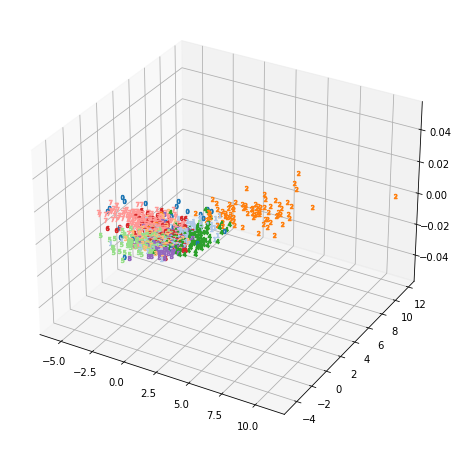

In [432]:
drawpoints_3d(X_2d_p_data,clustering_index(best_labeling))

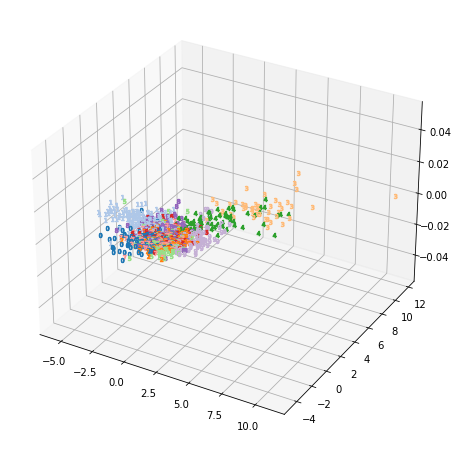

In [433]:
kmeans_model = KMeans(n_clusters=real_cluster_number, random_state=1).fit(X_2d_p_data)
drawpoints_3d(X_2d_p_data,kmeans_model.labels_)

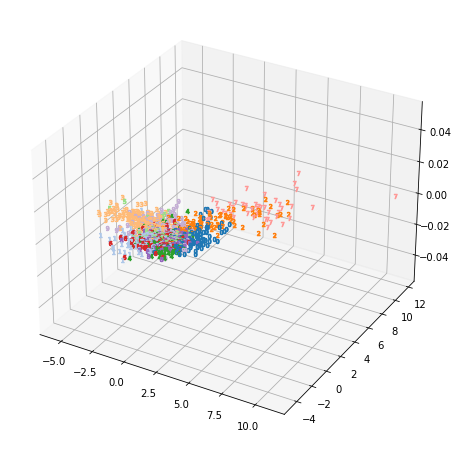

In [434]:
gauss_model = GaussianMixture(n_components=real_cluster_number,covariance_type='full',random_state=1).fit(X_2d_p_data)
drawpoints_3d(X_2d_p_data,gauss_model.predict(X_2d_p_data))

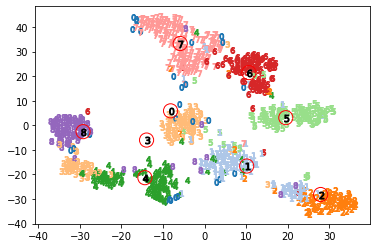

In [435]:
points = TSNE(n_components=2,random_state=0).fit_transform(X_2d_p_data)
drawpoints_with_centers(points,clustering_index(best_labeling),best_labeling)


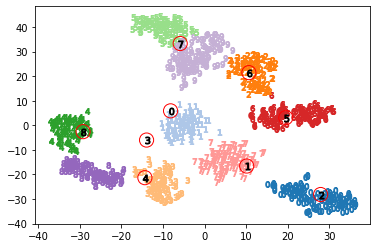

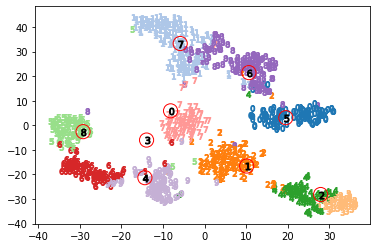

In [436]:
kmeans_model_afterTNSE = KMeans(n_clusters=real_cluster_number, random_state=1).fit(points)
drawpoints_with_centers(points,kmeans_model_afterTNSE.labels_,best_labeling)
drawpoints_with_centers(points,kmeans_model.labels_,best_labeling)

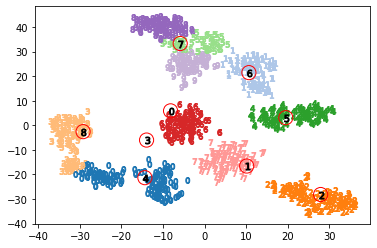

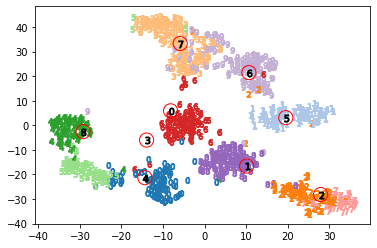

In [437]:
gauss_model_afterTNSE  = GaussianMixture(n_components=real_cluster_number,covariance_type='full',random_state=1).fit(points)
drawpoints_with_centers(points,gauss_model_afterTNSE.predict(points),best_labeling)
drawpoints_with_centers(points,gauss_model.predict(X_2d_p_data),best_labeling)

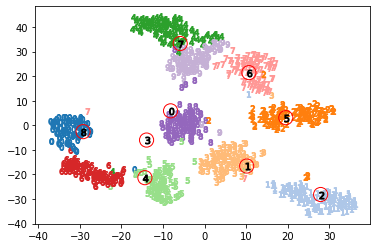

CPU times: user 9.82 s, sys: 0 ns, total: 9.82 s
Wall time: 9.81 s


In [438]:
%%time
drawpoints_with_centers(points,ts_p_l10,best_labeling)

In [308]:
points.shape

(1000, 2)